# Plot trends in OLR, ASR, and AIRS spectral OLR by month

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    stats, plot_trends
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load CERES-EBAF data

In [2]:
ceres_dir = '/glade/work/jonahshaw/obs/CERES'
ceres_file = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-202102.nc'

In [3]:
ceres_ds = xr.open_dataset('%s/%s' % (ceres_dir,ceres_file))

ceres_ds = ceres_ds.assign_coords(lon=(ceres_ds.lon % 360)).sortby('lon')

#### Add an absorbed solar radiation variable

In [4]:
ceres_ds['ASR'] = ceres_ds['solar_mon'] - ceres_ds['toa_sw_all_mon']

#### Add an albedo variable

In [5]:
temp_alb = (ceres_ds['toa_sw_all_mon'] / ceres_ds['solar_mon'])
# weird 2-step process required??
ceres_ds['albedo'] = temp_alb.where(ceres_ds['solar_mon'] > 15) #.where(temp_alb > 15,np.nan) # poorly defined when insolation is less than 15 W/m^2

### Plot month OLRs for the Arctic Ocean (70-90N)

If I want to use a better mask, should I use the LANDFRAC variable in CESM or is there something better?

In [7]:
olr_wgt = add_weights(ceres_ds['toa_lw_all_mon'])

In [8]:
month_groups = olr_wgt.groupby('time.month')

Compute monthly OLRs (inefficient, could vectorize)

In [9]:
olr_temp = []
labels = []

for label,month in month_groups:
    arc_ocn_avg = masked_average(month,weights=month['cell_weight'],mask=month.lat<70)
    
    olr_temp.append(arc_ocn_avg)
    labels.append(label)
#     break
olr_temp = np.array(olr_temp)

#### Sanity plot looks good

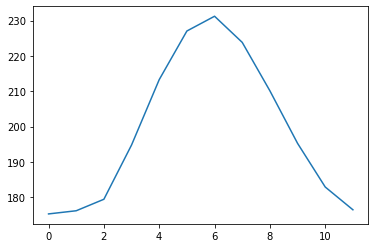

In [10]:
plt.plot(olr_temp)

### Plot a monthly trend

In [11]:
# average over the Arctic Ocean spatially, but not temporally
spat_avg = masked_average(olr_wgt,weights=olr_wgt['cell_weight'],mask=olr_wgt.lat<70,dim=['lat','lon'])

#### All months sanity plot looks good

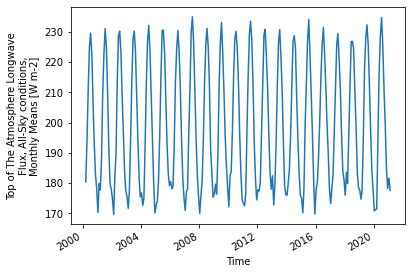

In [12]:
spat_avg.plot()

Text(0.5, 0.98, 'CERES OLR (70-90N)')

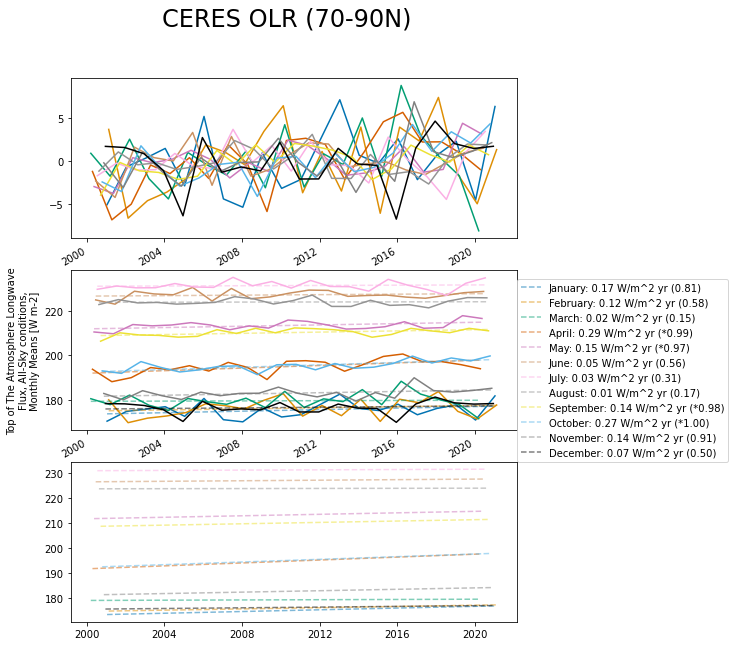

In [13]:
# For making month labels
mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

fig,axes = plt.subplots(3,1,figsize=(8,10))

lines=[]
mon_groups = spat_avg.groupby('time.month')

for color,(ind,mon) in zip(sns.color_palette("colorblind")+['grey','black'],mon_groups):
    mon_norm = mon - mon.mean() # normalize to the average

    out = regress_1d(mon['time.year'],mon)
    _slope, _intercept, _r_value, _p_value, _std_err =stats.linregress(mon['time.year'],mon)
    
    N=len(mon) # data point count (could be len(mon['time.year']) <-- same)
    std_x=np.std(mon['time.year']) # this works because each measurement is from a different year.
    std_y=np.std(mon)
    slope_calculated=_r_value*(std_y/std_x) # this is just getting the slope via the r-value and the stds
    
    ## ASSESS SIGNIFICANCE OF REGRESSION
#     print('Null Hypothesis: The true correlation is zero. ')
    dof=N-2
    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_r_value*np.sqrt(N-2)/np.sqrt((1-_r_value*_r_value))

#     if t>tcrit:
#         print('Since t=',np.round(t,2),'exceeds tcrit=',np.round(tcrit,2),' we can reject the null hypothesis')
#     if t<tcrit:
#         print('Since t=',np.round(t,2),'does not exceed tcrit=',np.round(tcrit,2),' we cannot reject the null hypothesis')
        
    statsig_percent=(1-_p_value)*100
#     print('stats.linregress statistical significance (%)',np.round(statsig_percent,0))
        
#     print(np.round(_slope,3))
#     print(np.round(slope_calculated.values,3))
    
    # These regressions have the same output, good check
#     print('regress coef: %.3f, regress intercept: %.3f' % (out.coef_,out.intercept_))
#     print('stats coef: %.3f, stats intercept: %.3f' % (_slope,_intercept))
    
    line = (mon['time.year'].values*_slope + _intercept).squeeze()
    if t>tcrit:
        label = '%s: %.2f W/m^2 yr (*%.2f)' % (mon_dict[str(ind)],_slope, (1-_p_value))
    else:
        label = '%s: %.2f W/m^2 yr (%.2f)' % (mon_dict[str(ind)],_slope, (1-_p_value))
    
    
    mon_norm.plot(label=label,ax=axes[0],color=color)
    out = mon.plot(label=label,ax=axes[1],color=color)
    
    axes[1].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)
    axes[2].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)    
    
    lines.append(out)
    
axes[2].legend(loc=[1,1])

fig.suptitle('CERES OLR (70-90N)',fontsize=24)

In [14]:
def plot_trends_dev(ds,title,units='W/m^2',seasonal=False,**kwargs):
    '''
    Create monthly and seasonal trend plots with 
    statistical significance testing.
    Needs to discard years when a whole season was not observed (a little dumb for DJF).
    
    '''

    # For making month labels
    mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
               '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
               }
    
    var_wgt = add_weights(ds)
    # average over the Arctic Ocean spatially, but not temporally
    try:
        spat_avg = masked_average(var_wgt,weights=var_wgt['cell_weight'],mask=var_wgt.lat<70,dim=['lat','lon'])
    except:
        spat_avg = masked_average(var_wgt,weights=var_wgt['cell_weight'],mask=var_wgt.latitude<70,dim=['latitude','longitude'])
        
    fig,axes = plt.subplots(3,1,figsize=(8,10),sharex=True)
    
    if seasonal:
        mon_groups = []

        for i,dat in spat_avg.groupby('time.season'):
            yr_grouped = dat.groupby('time.year') #.mean('time')
            
            # Select only years where all three months are included
            yr_cleaned = yr_grouped.where(yr_grouped.count() == 3).dropna('time').groupby('time.year').mean('time')
            
            mon_groups.append((i,yr_cleaned))
    else:
        mon_groups = spat_avg.groupby('time.month')

    for color,(ind,mon) in zip(sns.color_palette("colorblind")+['grey','black'],mon_groups):        
        mon_norm = mon - mon.mean() # normalize to the average

        if True in np.isnan(mon):
            print('nan in monthly averages for %s' % ind) # mon_dict[str(ind)])
#             print(mon.values)
        else:
            ## ASSESS SIGNIFICANCE OF REGRESSION
            time_str = 'year' if seasonal else 'time.year'

            _slope, _intercept, _r_value, _p_value, _std_err =stats.linregress(mon[time_str],mon)

            N=len(mon) # data point count (could be len(mon['time.year']) <-- same)

            dof=N-2
            tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
            t=_r_value*np.sqrt(N-2)/np.sqrt((1-_r_value*_r_value))

            statsig_percent=(1-_p_value)*100
            
            line = (mon[time_str].values*_slope + _intercept).squeeze()
#             print('tcrit:',tcrit,' t: ',t)
            time_label = ind if seasonal else mon_dict[str(ind)]
            if np.abs(t)>tcrit:
                label = '%s: %.2f %s /yr (*%.2f)' % (time_label,_slope, units, (1-_p_value))
            else:
                label = '%s: %.2f %s /yr (%.2f)' % (time_label,_slope, units, (1-_p_value))

            axes[0].plot(mon_norm[time_str],mon_norm,label=label,color=color,**kwargs) # mon_norm
            
            out = axes[1].plot(mon[time_str],mon,label=label,color=color,**kwargs)
            axes[1].plot(mon[time_str],line,alpha=0.5,linestyle='dashed',label=label,color=color,**kwargs) # was plotting by 'time' instead of 'time.year' originally
            
            axes[2].plot(mon[time_str],line,alpha=0.5,linestyle='dashed',label=label,color=color,**kwargs)
            
            axes[0].set_ylabel('%s (anomaly)' % units)
            axes[1].set_ylabel(units)
            axes[2].set_ylabel(units)
            axes[2].set_xlabel('Year')
            axes[2].set_xticks(mon[time_str][::4]) # Take every 4th year to avoid fractions

    axes[2].legend(loc=[1,1])

    fig.suptitle(title,fontsize=24)
    
    return mon[time_str]

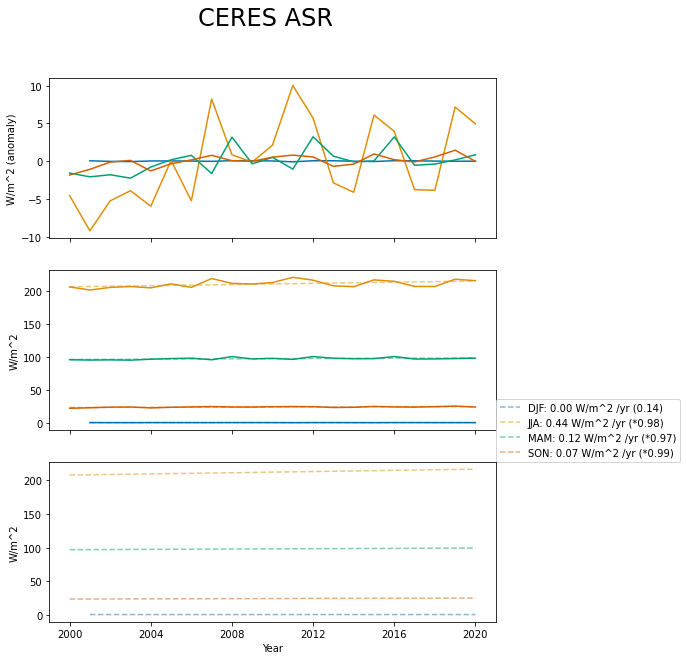

In [15]:
out = plot_trends_dev(ceres_ds['ASR'],'CERES ASR',seasonal=True)

In [16]:
ceres_ds['toa_lw_all_mon']

<xarray.DataArray 'toa_lw_all_mon' (time: 252, lat: 180, lon: 360)>
array([[[139.6, 139.6, 139.6, ..., 139.6, 139.6, 139.6],
        [138.7, 138.7, 138.7, ..., 138.7, 138.7, 138.7],
        [139. , 139. , 139. , ..., 139. , 139. , 139. ],
        ...,
        [174.4, 174.4, 174.4, ..., 174.4, 174.4, 174.4],
        [174.2, 174.2, 174.2, ..., 174.2, 174.2, 174.2],
        [175.5, 175.5, 175.5, ..., 175.5, 175.5, 175.5]],

       [[123.9, 123.9, 123.9, ..., 123.9, 123.9, 123.9],
        [124. , 124. , 124. , ..., 124. , 124. , 124. ],
        [125. , 125. , 125. , ..., 125. , 125. , 125. ],
        ...,
        [185.6, 185.6, 185.6, ..., 185.6, 185.6, 185.6],
        [186.2, 186.2, 186.2, ..., 186.2, 186.2, 186.2],
        [186.8, 186.8, 186.8, ..., 186.8, 186.8, 186.8]],

       [[120.4, 120.4, 120.4, ..., 120.4, 120.4, 120.4],
        [123. , 123. , 123. , ..., 123. , 123. , 123. ],
        [123.4, 123.4, 123.4, ..., 123.4, 123.4, 123.4],
        ...,
...
        ...,
        [172.3, 172.3, 172.3, ..., 172.3, 172.3, 172.3],
        [171.9, 171.9, 171.9, ..., 171.9, 171.9, 171.9],
        [173. , 173. , 173. , ..., 173. , 173. , 173. ]],

       [[188.3, 188.3, 188.3, ..., 188.3, 188.3, 188.3],
        [191.3, 191.3, 191.3, ..., 191.3, 191.3, 191.3],
        [191.8, 191.8, 191.8, ..., 191.8, 191.8, 191.8],
        ...,
        [180.2, 180.2, 180.2, ..., 180.2, 180.2, 180.2],
        [179.4, 179.4, 179.4, ..., 179.4, 179.4, 179.4],
        [178.9, 178.9, 178.9, ..., 178.9, 178.9, 178.9]],

       [[162.5, 162.5, 162.5, ..., 162.5, 162.5, 162.5],
        [166.1, 166.1, 166.1, ..., 166.1, 166.1, 166.1],
        [168.3, 168.3, 168.3, ..., 168.3, 168.3, 168.3],
        ...,
        [181.9, 181.9, 181.9, ..., 181.9, 181.9, 181.9],
        [180.3, 180.3, 180.3, ..., 180.3, 180.3, 180.3],
        [178.7, 178.7, 178.7, ..., 178.7, 178.7, 178.7]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 2000-03-15 2000-04-15 ... 2021-02-15
Attributes:
    long_name:      Top of The Atmosphere Longwave Flux, All-Sky conditions, ...
    standard_name:  TOA Longwave Flux - All-Sky
    CF_name:        toa_outgoing_longwave_flux
    comment:        none
    units:          W m-2
    valid_min:            0.00000
    valid_max:            400.000

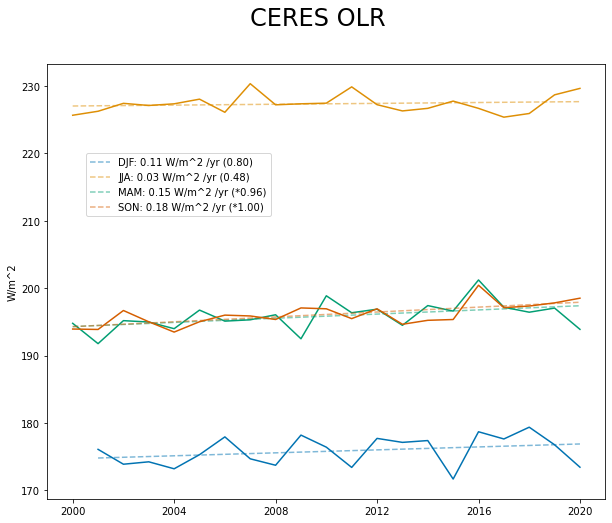

In [6]:
plot_trends(ceres_ds['toa_lw_all_mon'],'CERES OLR',seasonal=True,b_kwargs={'loc':(0.07,0.65)})

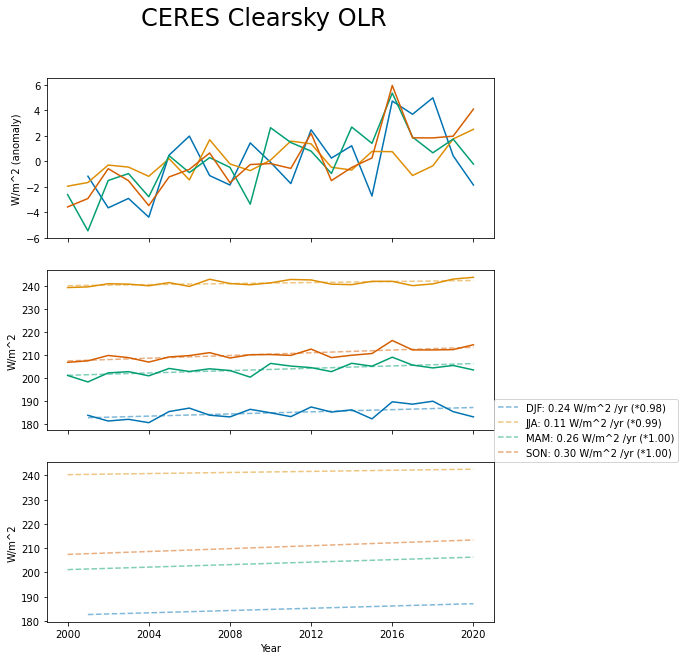

In [17]:
plot_trends(ceres_ds['toa_lw_clr_c_mon'],'CERES Clearsky OLR',seasonal=True)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


nan in monthly averages for 1
nan in monthly averages for 11
nan in monthly averages for 12


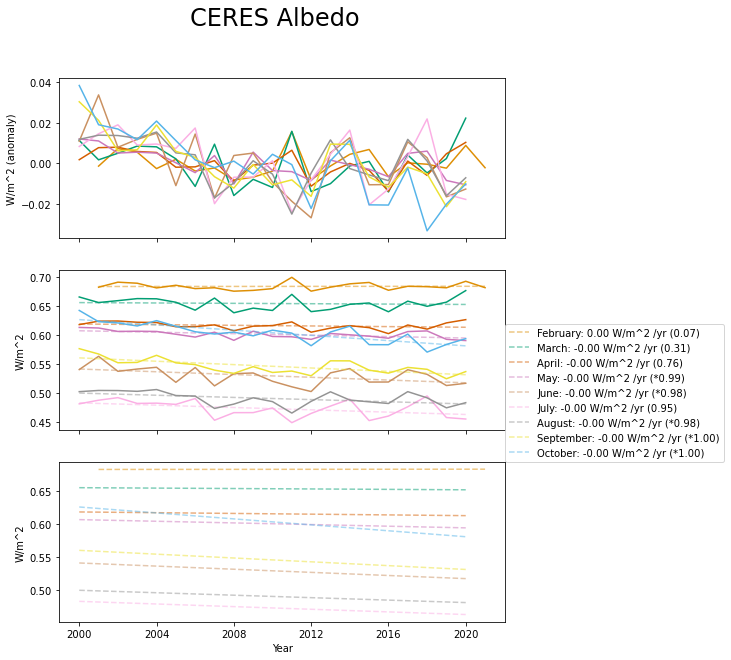

In [18]:
error = plot_trends(ceres_ds['albedo'],'CERES Albedo',seasonal=False)

The net energy budget change is interesting. More energy uptake in the summer and more energy emission in the fall. Sea ice loss seems to be the main driving trend, with fall surface temp increases second. I'm surprised that the winter trend is weak given the strong temperature increases then.

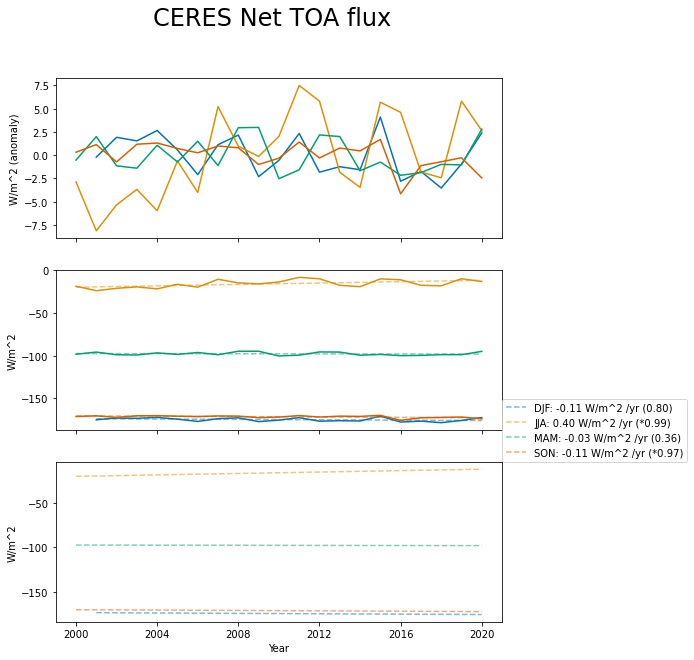

In [19]:
plot_trends(ceres_ds['toa_net_all_mon'],'CERES Net TOA flux',seasonal=True)

## Calculate trends for each lat/lon gridcell

I'd like to do this without nested for loops, but if it comes to that then ok.

In [20]:
def interp1d_np(data, x, xi):
    return np.interp(xi, x, data)


def trend_np(tseries,time):

    _slope, _intercept, _r_value, _p_value, _std_err =stats.linregress(time,tseries)
    return _slope

In [21]:
def sel_month(ds,imonth):
    return ds.sel(time = (ds['time.month'] == imonth))
    

### To get a good signal, look at OLR in October (increasing trend)

In [114]:
olr_oct = sel_month(ceres_ds['toa_lw_all_mon'],10)

olr_oct = olr_oct.groupby('time.year').mean('time')

### Use the xarray polyfit function (cheating) to get gridded trends

In [115]:
olr_trend = olr_oct.polyfit(dim='year',deg=1)['polyfit_coefficients'].sel(degree=1).squeeze()

#### Plot looks pretty good!

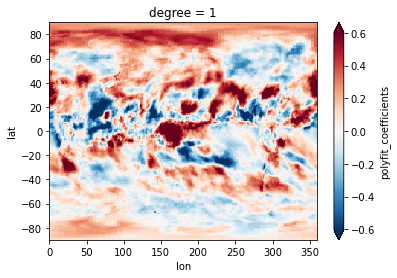

In [116]:
olr_trend.plot(robust=True)

#### Calculate a weighted average in the trend

In [117]:
olr_trend_wgt = add_weights(olr_trend)

trend_arc = masked_average(olr_trend_wgt,weights=olr_trend_wgt['cell_weight'],mask=olr_trend_wgt.lat<70)

trend_arc

<xarray.DataArray ()>
array(0.26549572)
Coordinates:
    degree   int64 1

#### For comparison, calculate a weighted average in the OLR and then trendify

In [118]:
olr_oct_wgt = add_weights(olr_oct)

olr_oct_spatavg = masked_average(olr_oct_wgt,weights=olr_oct_wgt['cell_weight'],mask=olr_oct_wgt.lat<70,dim=['lat','lon'])

In [119]:
slope,_,_,_,_ = stats.linregress(olr_oct_spatavg['year'],olr_oct_spatavg)

slope

0.2654952804763596

In [120]:
(trend_arc - slope) / slope

<xarray.DataArray ()>
array(1.66762066e-06)
Coordinates:
    degree   int64 1

### They are equal to a part in a million, so this appears to be working correctly!

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


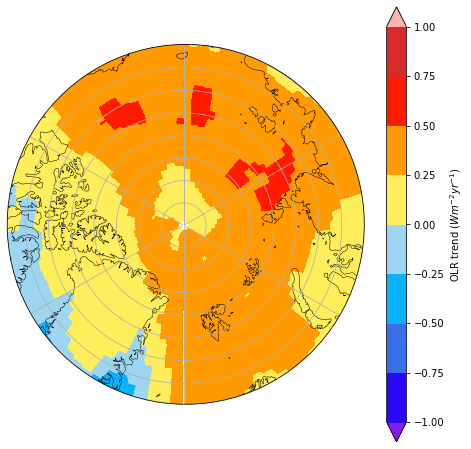

In [121]:
fig,ax = sp_map(nrows=1, ncols=1, projection=ccrs.NorthPolarStereo(), figsize=[8,8])

polarCentral_set_latlim([70,90], ax)

# im = olr_trend.where(month.lat>70).plot(ax=ax, transform=ccrs.PlateCarree())
# ax.contourf(olr_trend,transform=ccrs.NorthPolarStereo())
im = ax.contourf(olr_trend['lon'],olr_trend['lat'],olr_trend,transform=ccrs.PlateCarree(),cmap=cmaps.ncl_default,levels=np.linspace(-1,1,9),extend='both')
     
cbar = fig.colorbar(im)
cbar.set_label(r'OLR trend ($Wm^{-2}yr^{-1}$)')


add_map_features(ax)

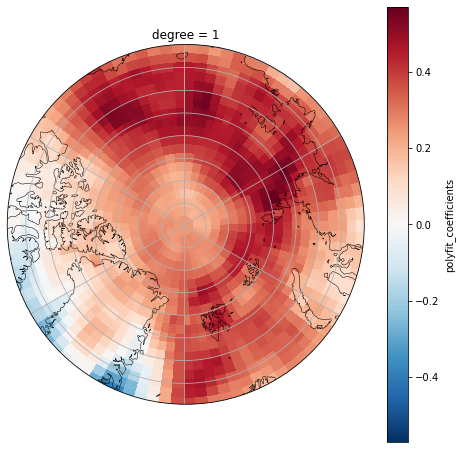

In [123]:
fig,ax = sp_map(nrows=1, ncols=1, projection=ccrs.NorthPolarStereo(), figsize=[8,8])

polarCentral_set_latlim([70,90], ax)

im = olr_trend.where(month.lat>70).plot(ax=ax, transform=ccrs.PlateCarree())
# im = ax.contourf(olr_trend['lon'],olr_trend['lat'],olr_trend,transform=ccrs.PlateCarree(),cmap=cmaps.ncl_default,levels=np.linspace(-1,1,9),extend='both')
     
# cbar = fig.colorbar(im)
# cbar.set_label(r'OLR trend ($Wm^{-2}yr^{-1}$)')


add_map_features(ax)

## Plot trends in surface temperature from the NASA GISS dataset

The GISS record runs from 1880 until 2021-01, whereas CERES runs 2002-03 to 2021-02.

In [22]:
gisstemp_path = '/glade/work/jenkay/obs/GISTEMP/'

In [23]:
giss1 = xr.open_dataset('%s/%s' % (gisstemp_path,'air.2x2.1200.mon.anom.comb.nc')) # longer time period here

In [24]:
giss_tsel = giss1.sel(time=slice('2000-03','2021-03'))

[<matplotlib.lines.Line2D object at 0x2abf677d9390>, <matplotlib.lines.Line2D object at 0x2abf677f5d90>, <matplotlib.lines.Line2D object at 0x2abf6745a910>, <matplotlib.lines.Line2D object at 0x2abf677c4090>]


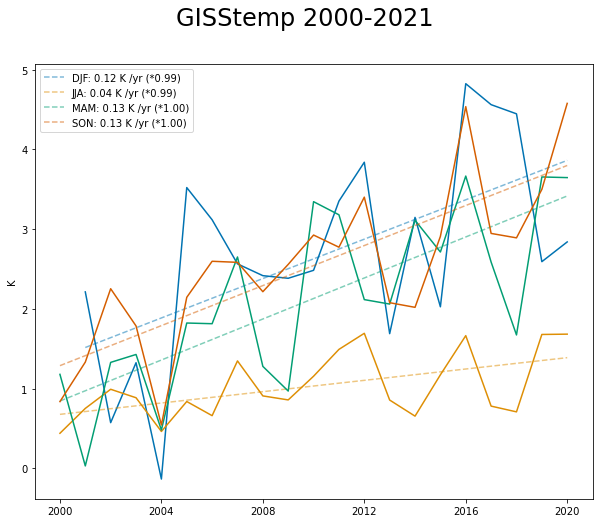

In [40]:
plot_trends(giss_tsel['air'],'GISStemp 2000-2021',units='K',seasonal=True)

### The GISS data shows the monthly anomaly, so there are no absolute temperature values

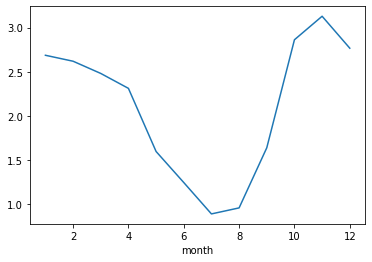

In [88]:
giss_T = add_weights(giss_tsel['air'])

spat_avg = masked_average(giss_T,weights=giss_T['cell_weight'],mask=giss_T.lat<70,dim=['lat','lon'])

spat_avg.groupby('time.month').mean('time').plot()

## GOCCP liquid cloud amount

In [63]:
goccp_dir = '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/grid_2x2_L40/'

In [64]:
# identifying strings
phase_str = 'Phase330m'
height_str = 'High330m'

In [65]:
height_files = glob.glob('%s/*/*%s*.nc' % (goccp_dir,height_str))
height_files.sort()

phase_files = glob.glob('%s/*/*%s*.nc' % (goccp_dir,phase_str))
phase_files.sort()

In [66]:
goccp_phase = xr.open_mfdataset(phase_files)
goccp_phase = goccp_phase.sel(time=slice('2008-01','2020-12'))

goccp_height = xr.open_mfdataset(height_files)
goccp_height = goccp_height.sel(time=slice('2008-01','2020-12'))

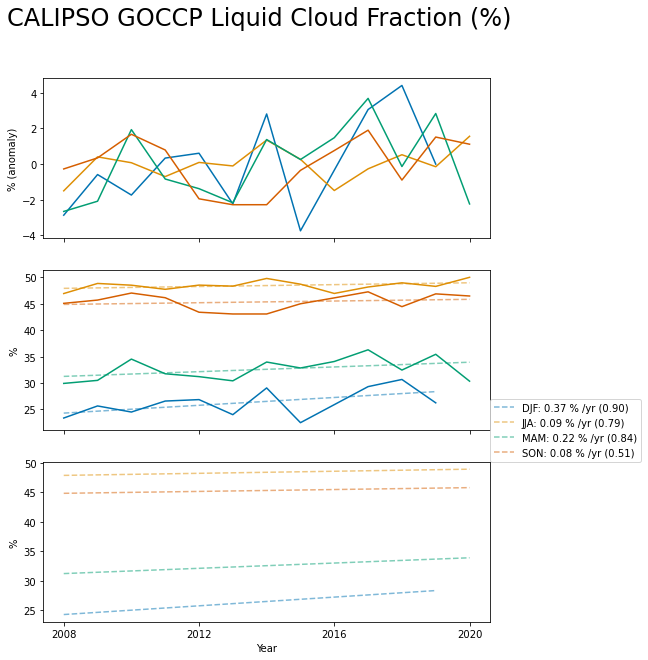

In [67]:
plot_trends(100*goccp_phase['cltcalipso_liq'],'CALIPSO GOCCP Liquid Cloud Fraction (%)',units='%',seasonal=True)

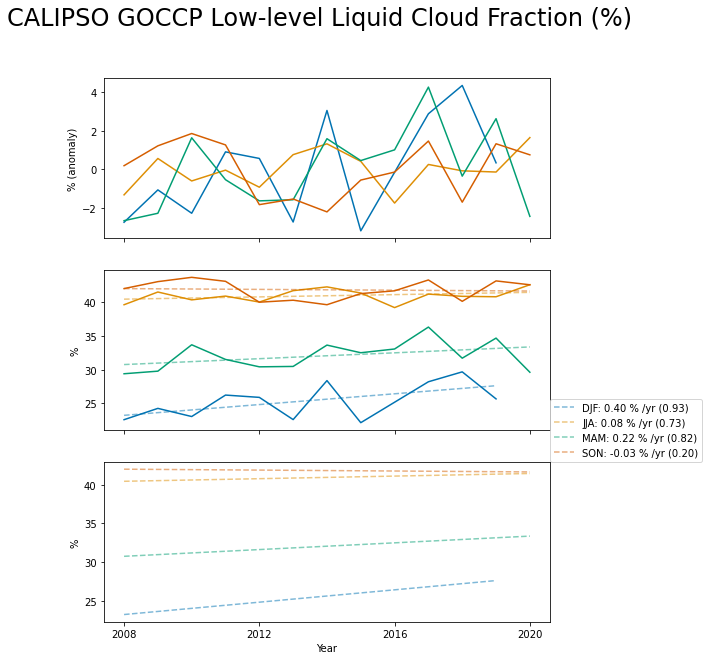

In [68]:
plot_trends(100*goccp_phase['cllcalipso_liq'],'CALIPSO GOCCP Low-level Liquid Cloud Fraction (%)',units='%',seasonal=True)

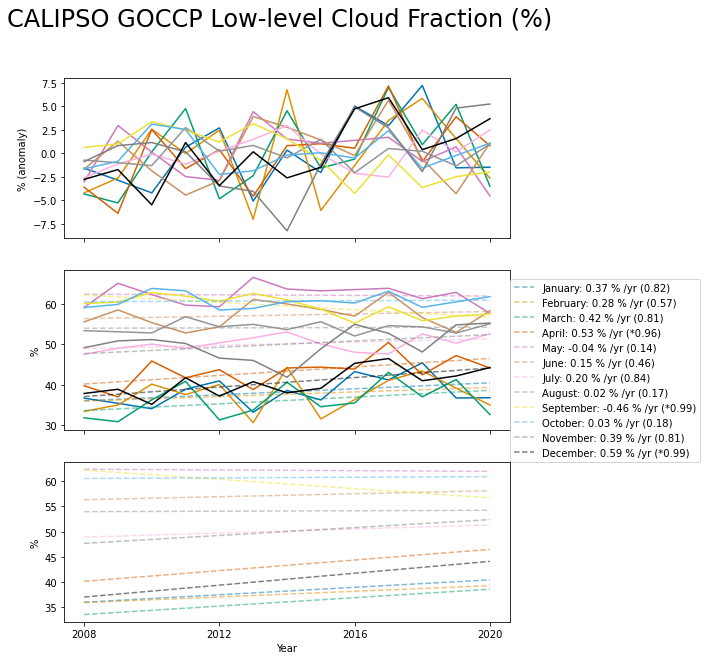

In [69]:
plot_trends(100*goccp_height['cllcalipso'],'CALIPSO GOCCP Low-level Cloud Fraction (%)',units='%')

### This is interesting! Why is there less low-level cloud in August, September, and October?

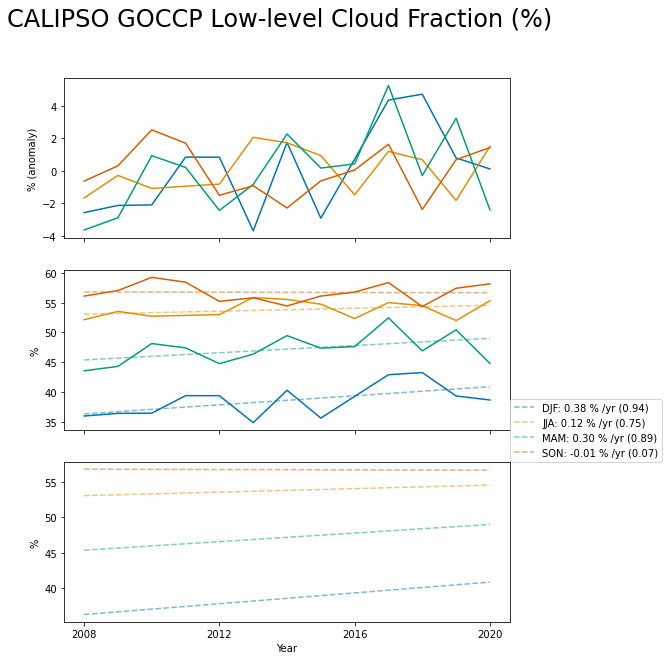

In [70]:
plot_trends(100*goccp_height['cllcalipso'],'CALIPSO GOCCP Low-level Cloud Fraction (%)',units='%',seasonal=True)

In [71]:
def is_aso(month): # August, September, October selection, returns an iterable of booleans
    return (month >= 8) & (month <= 10)


In [78]:
def plot_trends_simp(ds,time_var='time',units='W/m^2',title='Trends????',var_name=None):
    '''
    To call for processed data
    '''
    
    fig,ax = plt.subplots(1,1,figsize=(10,6))
    
    # For making month labels
    mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
               '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
               }
    
    var_wgt = add_weights(ds)
    # average over the Arctic Ocean spatially, but not temporally
    try:
        spat_avg = masked_average(var_wgt,weights=var_wgt['cell_weight'],mask=var_wgt.lat<70,dim=['lat','lon'])
    except:
        spat_avg = masked_average(var_wgt,weights=var_wgt['cell_weight'],mask=var_wgt.latitude<70,dim=['latitude','longitude'])
            
    _slope, _intercept, _r_value, _p_value, _std_err =stats.linregress(spat_avg[time_var],spat_avg)

    N=len(spat_avg) # data point count (could be len(mon['time.year']) <-- same)

    dof=N-2
    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_r_value*np.sqrt(N-2)/np.sqrt((1-_r_value*_r_value))

    statsig_percent=(1-_p_value)*100

    line = (spat_avg[time_var].values*_slope + _intercept).squeeze()
#             print('tcrit:',tcrit,' t: ',t)
#     time_label = ind if seasonal else mon_dict[str(ind)]
    if np.abs(t)>tcrit:
        label = '%.2f %s /yr (*%.2f)' % (_slope, units, (1-_p_value))
    else:
        label = '%.2f %s /yr (%.2f)' % (_slope, units, (1-_p_value))

    ax.plot(spat_avg[time_var],spat_avg,label=None,color='black')
    ax.plot(spat_avg[time_var],line,alpha=0.5,linestyle='dashed',label=label,color='grey') # was plotting by 'time' instead of 'time.year' originally

    ax.set_ylabel('%s (%s)' % (var_name,units))
    ax.set_xlabel('Year')
    ax.legend() # loc=[1,1]

    fig.suptitle(title,fontsize=24)

In [76]:
seasonal_data = goccp_height['cllcalipso'].sel(time=is_aso(goccp_height['time.month']))

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


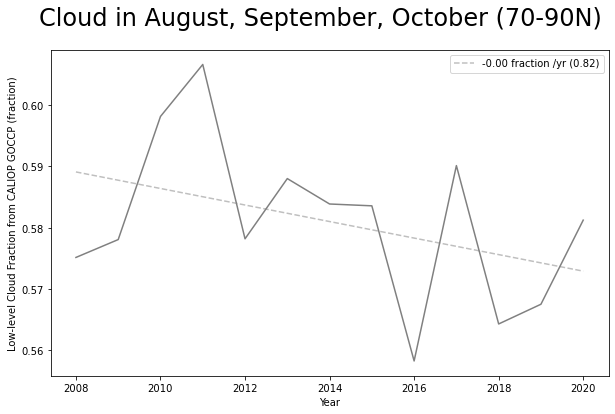

In [77]:
plot_trends_simp(seasonal_data.groupby('time.year').mean('time'),time_var='year',title='Cloud in August, September, October (70-90N)',var_name='Low-level Cloud Fraction from CALIOP GOCCP',units='fraction')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


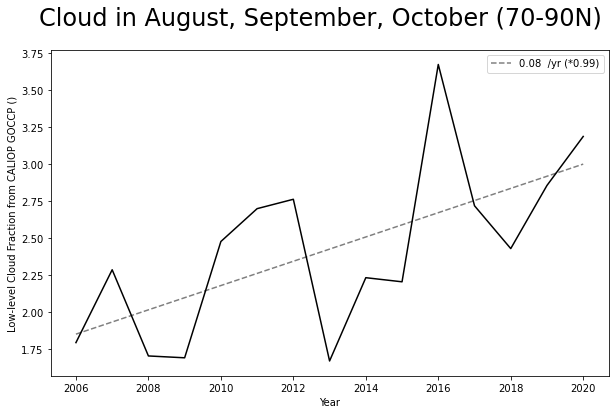

In [67]:
giss_caliop = giss1.sel(time=slice('2006-06','2020-12'))

plot_trends_simp(giss_caliop['air'].groupby('time.year').mean('time'),time_var='year',title='Cloud in August, September, October (70-90N)',var_name='Low-level Cloud Fraction from CALIOP GOCCP',units='')

In [ ]:
giss_tsel['air']

In [57]:
seasonal_data.groupby('time.year').mean('time')

<xarray.DataArray 'cllcalipso' (year: 15, latitude: 90, longitude: 180)>
dask.array<stack, shape=(15, 90, 180), dtype=float32, chunksize=(1, 90, 180), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * longitude  (longitude) float32 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * year       (year) int64 2006 2007 2008 2009 2010 ... 2017 2018 2019 2020

In [105]:
out = goccp_height['cltcalipso'].where(goccp_height['time.month']==slice(7,9))

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


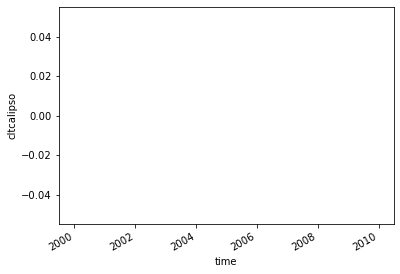

In [108]:
out.mean(dim=['latitude','longitude']).plot()

### Old stuff

In [48]:
xr.apply_ufunc(
    trend_np,  # first the function
    month_ex.isel(lat=0, lon=0),  # now arguments in the order expected by 'interp1_np'
    month_ex.isel(lat=0, lon=0)['year'],  # now arguments in the order expected by 'interp1_np'
#     air.lat,
#     newlat,
)

ValueError: applied function returned data with unexpected number of dimensions: 0 vs 1, for dimensions ('year',)

In [26]:
newlat = np.linspace(15, 75, 100)

air = (
    xr.tutorial.load_dataset("air_temperature")
    .air.sortby("lat")  # np.interp needs coordinate in ascending order
    .isel(time=slice(4), lon=slice(3))
)  # choose a small subset for convenience
air

<xarray.DataArray 'air' (time: 4, lat: 25, lon: 3)>
array([[[296.29   , 296.79   , 297.1    ],
        [295.9    , 296.19998, 296.79   ],
        [296.6    , 296.19998, 296.4    ],
        [297.     , 296.69998, 296.1    ],
        [295.4    , 295.69998, 295.79   ],
        [293.79   , 294.1    , 294.6    ],
        [293.1    , 293.29   , 293.29   ],
        [290.19998, 290.79   , 291.4    ],
        [287.9    , 288.     , 288.29   ],
        [286.5    , 286.5    , 285.69998],
        [284.6    , 284.9    , 284.19998],
        [282.79   , 283.19998, 282.6    ],
        [280.     , 280.69998, 280.19998],
        [278.4    , 279.     , 279.     ],
        [277.29   , 277.4    , 277.79   ],
        [276.69998, 277.4    , 277.69998],
        [275.9    , 276.9    , 276.9    ],
        [274.79   , 275.19998, 275.6    ],
        [273.69998, 273.6    , 273.79   ],
        [272.1    , 270.9    , 270.     ],
...
        [293.     , 293.5    , 294.29   ],
        [291.9    , 291.9    , 292.19998],
        [289.19998, 289.4    , 289.9    ],
        [286.6    , 287.1    , 287.9    ],
        [284.79   , 284.79   , 285.4    ],
        [282.79   , 282.     , 282.69998],
        [281.19998, 280.19998, 280.6    ],
        [279.5    , 278.69998, 278.6    ],
        [278.     , 277.69998, 277.6    ],
        [276.4    , 275.9    , 276.4    ],
        [275.6    , 275.69998, 276.1    ],
        [274.5    , 275.6    , 276.29   ],
        [273.4    , 274.5    , 275.5    ],
        [274.1    , 274.     , 273.5    ],
        [273.29   , 272.6    , 271.5    ],
        [272.79   , 272.4    , 271.9    ],
        [267.69998, 266.29   , 264.4    ],
        [256.6    , 254.7    , 252.09999],
        [246.29999, 245.29999, 244.2    ],
        [241.89   , 241.79999, 241.79999]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 15.0 17.5 20.0 22.5 25.0 ... 65.0 67.5 70.0 72.5 75.0
  * lon      (lon) float32 200.0 202.5 205.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-01-01T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [27]:
xr.apply_ufunc(
    interp1d_np,  # first the function
    air.isel(time=0, lon=0),  # now arguments in the order expected by 'interp1_np'
    air.lat,
    newlat,
)

ValueError: size of dimension 'lat' on inputs was unexpectedly changed by applied function from 25 to 100. Only dimensions specified in ``exclude_dims`` with xarray.apply_ufunc are allowed to change size.

In [92]:
def time_trend(tseries,axis=None,time_str='time',season=None):
    '''
    Return a slope
    '''
    
    print(tseries.shape)
    _slope, _intercept, _r_value, _p_value, _std_err =stats.linregress(tseries[axis],tseries)
#     stats.
    return _slope
    
    
def trend_signif(tseries):
    
    
    return None

In [57]:
arc_ocn_avg = masked_average(month,weights=month['cell_weight'],mask=month.lat>70)

In [58]:
arc_ocn_avg

<xarray.DataArray ()>
array(239.40678, dtype=float32)
Attributes:
    long_name:      Top of The Atmosphere Longwave Flux, All-Sky conditions, ...
    standard_name:  TOA Longwave Flux - All-Sky
    CF_name:        toa_outgoing_longwave_flux
    comment:        none
    units:          W m-2
    valid_min:            0.00000
    valid_max:            400.000

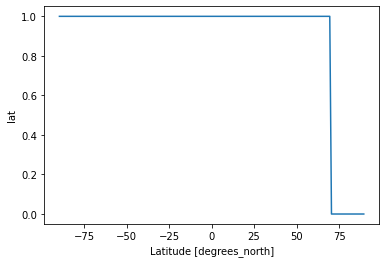

In [55]:
(month.lat<70).plot()

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


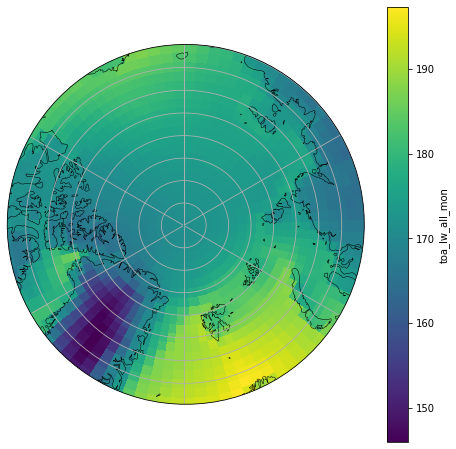

In [43]:
fig,ax = sp_map(nrows=1, ncols=1, projection=ccrs.NorthPolarStereo(), figsize=[8,8])

polarCentral_set_latlim([70,90], ax)

month.where(month.lat>70).mean('time').plot(ax=ax, transform=ccrs.PlateCarree())

add_map_features(ax)

In [21]:
type(group)

xarray.core.dataarray.DataArray

In [33]:
ax.plot(month.where(month.lat>70).mean('time'),projection=ccrs.NorthPolarStereo())

AttributeError: 'Line2D' object has no property 'projection'

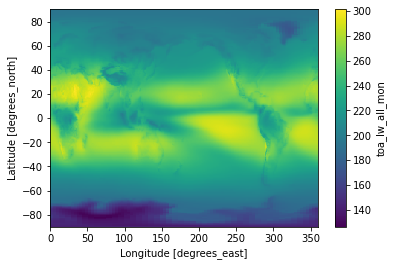

In [9]:
ceres_ds['toa_lw_all_mon'].mean('time').plot()

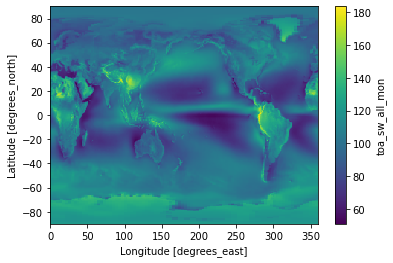

In [10]:
ceres_ds['toa_sw_all_mon'].mean('time').plot()

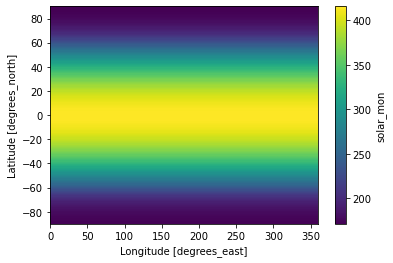

In [11]:
ceres_ds['solar_mon'].mean('time').plot()

In [ ]:
OSR=ds.toa_sw_all_mon.mean('time') ### outgoing solar radiation, measured by CERES
SOLIN=ds.solar_mon.mean('time')    ### incoming solar radiation, from the sun
ASR=SOLIN-OSR  ### sign convention, positive down.  incoming solar radiation minus outgoing solar radiation